In [2]:
import lightkurve as lk


import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np

# import pandas as pd #optional (may be used in future)

import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
from astropy.io import fits
# print(astropy.__version__) #it's good to check if BLS doesn't import properly. It's only in new versions.

import batman
from transitleastsquares import catalog_info
from transitleastsquares import period_grid

import wotan
from wotan import flatten

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #<--these are annoying


## Let's Try with synthetic light curve with a rapid rotating "star"

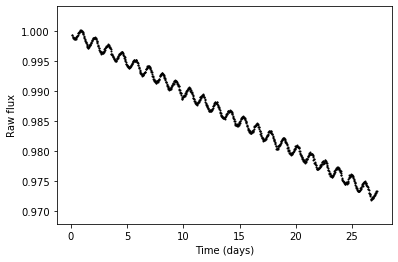

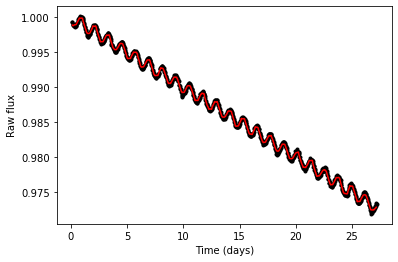

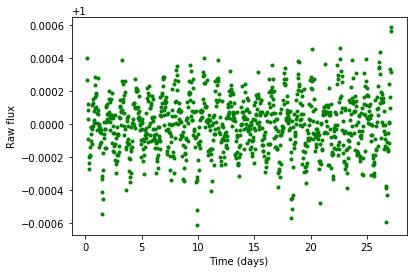

period of variability:  1.2034738542942789


In [3]:


points = 1000
time = np.linspace(0.1, 27.2, points)

#randomizing flux to have random variability and trends

amplitude= np.random.randint(1.,3)

minfreq = 2*np.pi/1.0; maxfreq = 2*np.pi/3.0
frequency =np.random.uniform(minfreq, maxfreq) 
#^^^ range decided by M-dwarf field star survey
# https://www.semanticscholar.org/paper/M-DWARF-RAPID-ROTATORS-AND-THE-DETECTION-OF-YOUNG-Rappaport-Swift/1b7e183659ddad11efb23ba68e7d11a0b07f5d1c/figure/0


offset = 0#time/np.random.randint(1,2) 
sinewave = np.sin(time*frequency+offset) #simple harmonic oscillation


linear_trend = (time**np.random.randint(0,2))/np.random.randint(1,2)


flux = 1 + ( (sinewave +  linear_trend) / 1000)

noise = np.random.normal(0, 0.0001, points)
flux += noise
# add errors
dy = 0.1
error = np.ones_like(flux)*dy #np.random.normal(flux, dy)


#injecting planet
Rad_sun = 6.955*10.0**10.0 #cm
Rad_earth = 6.378*10.0**8.0 #cm
Mass_sun = 1.989*10.0**33.0 #grams

R_star = 0.1 *Rad_sun
M_star = 0.1*Mass_sun
time_start = time[51] #[51] =fiftieth data point in array

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
ma.per = np.random.uniform(1,5)#2.345  # orbital period
ma.rp = np.random.uniform(1,5)*Rad_earth/Rad_sun#3.0*Rad_earth/Rad_sun  # planet radius (in units of stellar radii) 
ma.a =  5  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = [0.4, 0.4]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, time)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

injectedflux = synthetic_signal- flux+1


plt.scatter(time, injectedflux, s=1, color='black')
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
# plt.xlim(0, 15)
# plt.ylim(0.999, 1.0035);
plt.show();


flatten_lc, trend_lc = flatten(time, injectedflux, window_length=0.5, return_trend=True,robust=True,method='biweight')

plt.plot(time, injectedflux, 'k.')
plt.plot(time, trend_lc, 'r-')
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
# plt.xlim(-1, 16)
# plt.ylim(0.999, 1.0035);
plt.show();


plt.plot(time, flatten_lc, 'g.',linewidth=2 )
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
# plt.xlim(-1, 16)
# plt.ylim(0.999, 1.0035);
plt.show();


print("period of variability: ",2*np.pi/frequency)

zoom in on 10 day region


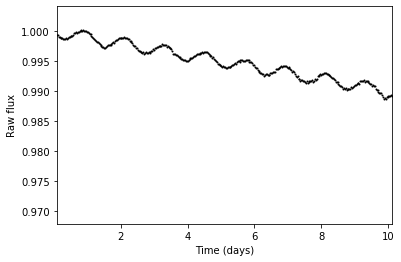

In [4]:
print('zoom in on 10 day region')
plt.scatter(time, injectedflux, s=1, color='black')
plt.xlabel('Time (days)')
plt.ylabel('Raw flux')
plt.xlim(time[0], time[0]+10)
# plt.ylim(0.999, 1.0035);
plt.show();

## Rapidly rotating stars are a problem...
## Idea: Use a Lomb-Scargle to identify a rotational period as a prior, then apply a gaussian process to fit a quasi-periodic kernal to the data

## (See Angus et al. 2018) 

https://watermark.silverchair.com/stx2109.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAmAwggJcBgkqhkiG9w0BBwagggJNMIICSQIBADCCAkIGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMTKtHOCP94BhDn4ciAgEQgIICE6k0o-kwWvLG16VJuWS0ZZPz30tifbW2rVYcC6XRMwGqbTX1FuDDkL5mM314Icwg4jCm8UTZIIPK_9Q3A12ORk0TBTJf6VN5iuoTkHGi5RpnFPFDDnfuUNnoGLg2lewExBlvii-GdH_VLxAScpaWOEtC9JK-Y_SVzszjWs_uQ0IzaeCpkaZz1nskSrQ9YuINahEuGRipeuDir_2zmMdhoDQgyuMbGKSZXAdIw-_nnbMG5Vu3R7HTZZ2sQXyATAJX2BzbpK2jPkqiHJQhpOeEMcgbrPXPABtpj7J4OKZdp9RqYEb11GEHPpwtPgTI2ags8BrvkSx2FoA8YCvawiwdyQzx_3wK7oqAsj5NLhBPMrIaca9M2XrgVi0QR86ChDfDYzyQg_g3-2mqkFxXfJb15dGqYMJ-mRrWr_kI4i4t7lf7I16bBX9pYecxEbnBp_W6u3usUAD5iDRL4_dxB41p1FG-ei5MmgpSlYI6-uJLXarAJPBfKfCw3HBmGjxHpnjgT7Vj7qpga81yBfnSJMFBLARcViBTXoyqTCsabAr_w_dYOO7L1A93ZDtXiSsBGDXKVC5DaMFpRzGrpElVTF6XN6X-aHSAa08yenD_cdxpzVx22cbpF6-_7rMBeEjoBIbl0O8huj3JBAgt28FNuSuLvLEqMArhDQDkd5MoMVzg9jYFN9NcS01lcybwR7vbEiIkNn_xoQ

        Use astropy.stats.LombScargle instead. [warnings]


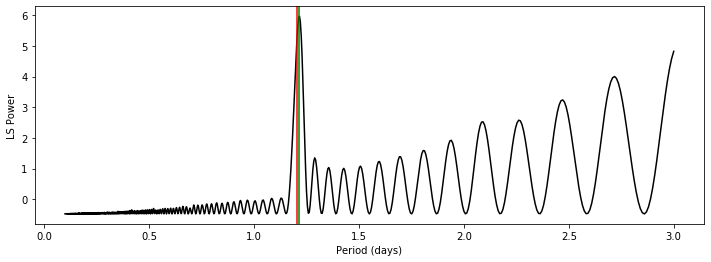

compare with injected variability period:  1.2034738542942789 ; LS result:  1.21700480593833


In [5]:
from astroML.time_series import lomb_scargle

# Compute periodogram
minP=0.1; maxP=3
# period = np.linspace(minP,maxP, 1000)

minP=np.log10(0.1); maxP=np.log10(3)
period = 10 ** np.linspace(minP, maxP, 1000)
# period = np.linspace(minP,maxP, 1000)
freq = 2.0 * np.pi / period
PS = lomb_scargle(time, injectedflux, error,omega=freq, generalized=True)
Standpower = (PS-np.mean(PS))/np.std(PS)

plt.figure(figsize=(12,4))
plt.plot(period,Standpower,'k')
plt.axvline(x=2*np.pi/frequency,color='r')
plt.axvline(x=period[np.argmax(Standpower)],color='g')
# plt.xlim(1,(2*np.pi/frequency)+2.5)
plt.ylabel("LS Power")
plt.xlabel("Period (days)")
plt.show()

print("compare with injected variability period: ",(2*np.pi/frequency), "; LS result: ",period[np.argmax(Standpower)])


# LS seems to consistently fail to recover an accurate estimate of simulated variability when there is an offset in phase $\sin(wt+\phi)$ ...

Currently the offset is set to 0

length scale:  20
Segment 1 of 1


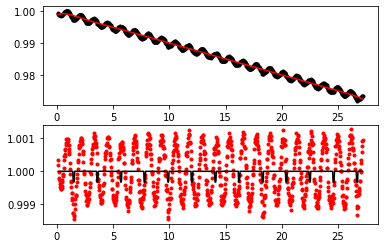

length scale:  10
Segment 1 of 1


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.73400814e+01, 1.44390799e+01, 6.98194262e+04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


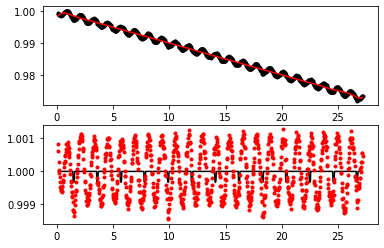

length scale:  5
Segment 1 of 1


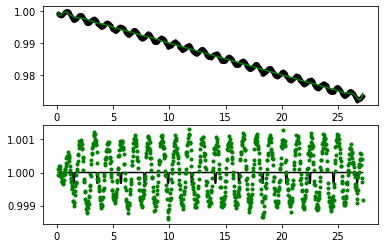

length scale:  2
Segment 1 of 1


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.38832965e-01, -7.73045115e-01,  3.46807754e+03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


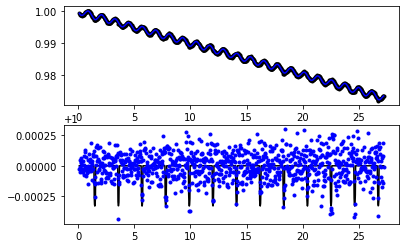

length scale:  1
Segment 1 of 1


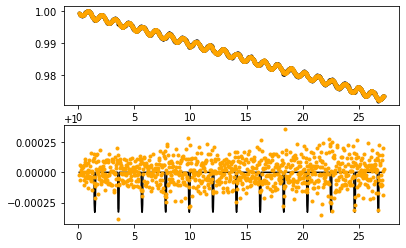

In [6]:
length_scale1 =20 #how close do data points have to be to be correlated?
print('length scale: ',length_scale1)
gpflatten_lc1, gptrend_lc1 = flatten(time,injectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale1,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(time, injectedflux, 'k.')
plt.plot(time,gptrend_lc1,'r-')
fig.add_subplot(212)
plt.plot(time,gpflatten_lc1,color='r',marker='.',linestyle='none')
plt.plot(time,synthetic_signal,'k')
plt.show()

length_scale1 =10 #how close do data points have to be to be correlated?
print('length scale: ',length_scale1)
gpflatten_lc1, gptrend_lc1 = flatten(time,injectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale1,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(time, injectedflux, 'k.')
plt.plot(time,gptrend_lc1,'r-')
fig.add_subplot(212)
plt.plot(time,synthetic_signal,'k')
plt.plot(time,gpflatten_lc1,color='r',marker='.',linestyle='none')
plt.show()


length_scale2 =5 #how close do data points have to be to be correlated?
print('length scale: ',length_scale2)
gpflatten_lc2, gptrend_lc2 = flatten(time,injectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale2,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(time, injectedflux, 'k.')
plt.plot(time,gptrend_lc2,'g-')
fig.add_subplot(212)
plt.plot(time,synthetic_signal,'k')
plt.plot(time,gpflatten_lc2,color='g',marker='.',linestyle='none')
plt.show()


length_scale3 =2 #how close do data points have to be to be correlated?
print('length scale: ',length_scale3)
gpflatten_lc3, gptrend_lc3 = flatten(time,injectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale3,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(time, injectedflux, 'k.')
plt.plot(time,gptrend_lc3,'b-')
fig.add_subplot(212)
plt.plot(time,synthetic_signal,'k')
plt.plot(time,gpflatten_lc3,color='b',marker='.',linestyle='none')
plt.show()

length_scale4 =1 #how close do data points have to be to be correlated?
print('length scale: ',length_scale4)
gpflatten_lc4, gptrend_lc4 = flatten(time,injectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale4,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(time, injectedflux, 'k.')
plt.plot(time,gptrend_lc4,color='orange',marker='.',linestyle='-')
fig.add_subplot(212)
plt.plot(time,synthetic_signal,'k')
plt.plot(time,gpflatten_lc4,color='orange',marker='.',linestyle='none')

plt.show()

1.21700480593833
length scale:  2
Segment 1 of 1


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.38832965e-01, -7.73045115e-01,  3.46807754e+03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


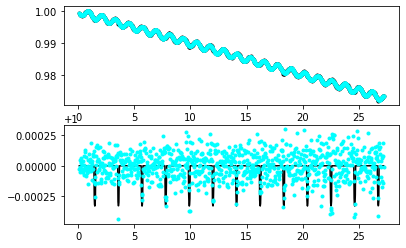

how far off is this fit? -0.00010856667190273228


In [7]:
#  even smaller length scales?
# length_scale5 =float(input())#how close do data points have to be to be correlated?

print(period[np.argmax(Standpower)])
if period[np.argmax(Standpower)]/4.0 > 1: #randomly selected 
    length_scale5=period[np.argmax(Standpower)]/4.0
    print("length scale: ",length_scale5)
else:
    length_scale5=2
    print('length scale: ',length_scale5)
    

gpflatten_lc5, gptrend_lc5 = flatten(time,injectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale5,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(time, injectedflux, 'k.')
plt.plot(time,gptrend_lc5,color='cyan',marker='.',linestyle='-')
fig.add_subplot(212)
plt.plot(time,synthetic_signal,'k')
plt.plot(time,gpflatten_lc5,color='cyan',marker='.',linestyle='none')
plt.show()

print("how far off is this fit?", np.min(gpflatten_lc5)-np.min(synthetic_signal))

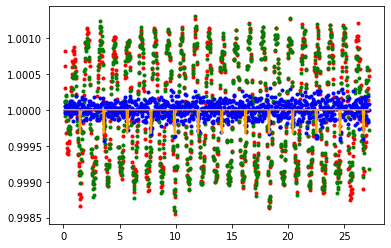

In [8]:
plt.plot(time,gpflatten_lc1,'r.')
plt.plot(time,gpflatten_lc2,'g.')
plt.plot(time,gpflatten_lc3,'b.')
plt.plot(time,synthetic_signal,'orange')
plt.show()

## Now let's test if gaps in data are a problem

no gap


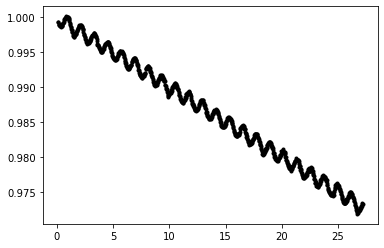

with gap


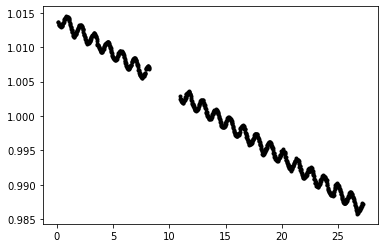

In [9]:
print("no gap")
plt.plot(time,injectedflux,'k.')
plt.show()
time[300:400] = np.nan
injectedflux[300:400] = np.nan



mask = np.where(np.isnan(injectedflux)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
newtime = time[mask]                        #Sometimes there are holes in data filled with NaNs
newinjectedflux = injectedflux[mask]/np.mean(injectedflux[mask])
newsynthetic_signal = synthetic_signal[mask]
print("with gap")
plt.plot(newtime,newinjectedflux,'k.')
plt.show()

length scale:  10
Segment 1 of 2
Segment 2 of 2


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.07555510e+01, 2.50951864e+01, 9.41910801e+04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 26, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


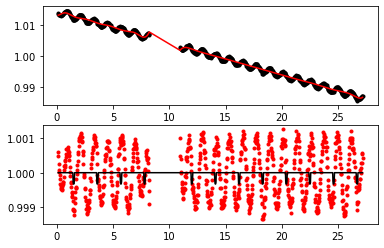

length scale:  5
Segment 1 of 2
Segment 2 of 2


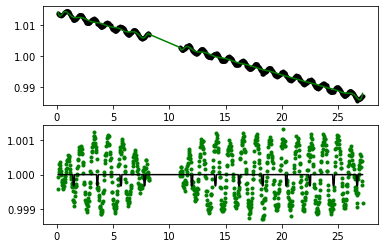

length scale:  2
Segment 1 of 2


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.27373363e-02, -8.06752715e-02,  1.31901300e+03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


Segment 2 of 2


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.38312218e-01, -1.34774765e-01,  6.41271586e+02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


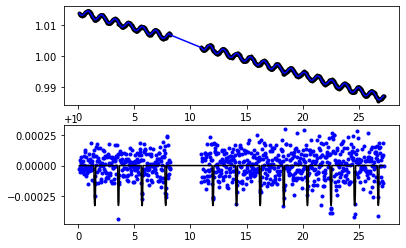

length scale:  1
Segment 1 of 2


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.87584168e-01, -1.54335983e-02,  1.03008695e+04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


Segment 2 of 2


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.09777546e-01, 4.45371509e-02, 3.62236746e+04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


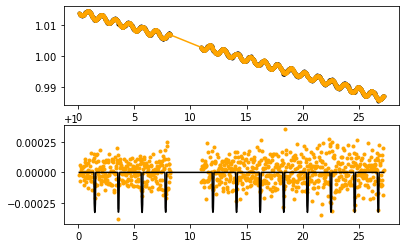

In [10]:
length_scale1 =10 #how close do data points have to be to be correlated?
print('length scale: ',length_scale1)
gpflatten_lc1b, gptrend_lc1b = flatten(newtime,newinjectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale1,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(newtime, newinjectedflux, 'k.')
plt.plot(newtime,gptrend_lc1b,'r-')
fig.add_subplot(212)
plt.plot(newtime,gpflatten_lc1b,'r.')
plt.plot(newtime,newsynthetic_signal,'k')
plt.show()


length_scale2 =5 #how close do data points have to be to be correlated?
print('length scale: ',length_scale2)
gpflatten_lc2b, gptrend_lc2b = flatten(newtime,newinjectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale2,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(newtime, newinjectedflux, 'k.')
plt.plot(newtime,gptrend_lc2b,'g-')
fig.add_subplot(212)
plt.plot(newtime,gpflatten_lc2b,'g.')
plt.plot(newtime,newsynthetic_signal,'k')
plt.show()


length_scale3 =2 #how close do data points have to be to be correlated?
print('length scale: ',length_scale3)
gpflatten_lc3b, gptrend_lc3b = flatten(newtime,newinjectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale3,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(newtime, newinjectedflux, 'k.')
plt.plot(newtime,gptrend_lc3b,'b-')
fig.add_subplot(212)
plt.plot(newtime,gpflatten_lc3b,'b.')
plt.plot(newtime,newsynthetic_signal,'k')
plt.show()


length_scale4 =1 #how close do data points have to be to be correlated?
print('length scale: ',length_scale4)
gpflatten_lc4b, gptrend_lc4b = flatten(newtime,newinjectedflux,method='gp',
    kernel='periodic_auto',kernel_size=length_scale4,return_trend=True,robust=True)

fig=plt.figure()
fig.add_subplot(211)
plt.plot(newtime, newinjectedflux, 'k.')
plt.plot(newtime,gptrend_lc4b,color='orange',marker='.',linestyle='-')
fig.add_subplot(212)
plt.plot(newtime,gpflatten_lc4b,color='orange',marker='.',linestyle='none')
plt.plot(newtime,newsynthetic_signal,'k')
plt.show()

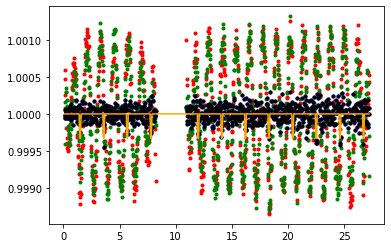

length scale of 1 to 2 typically does pretty well


In [11]:
plt.plot(newtime,gpflatten_lc1b,'r.')
plt.plot(newtime,gpflatten_lc2b,'g.')
plt.plot(newtime,gpflatten_lc3b,'b.')
plt.plot(newtime,gpflatten_lc3b,'k.')
plt.plot(newtime,newsynthetic_signal,'orange')
plt.show()

print("length scale of 1 to 2 typically does pretty well")

# With rotation effects removed, let's see if BLS can accurately recover our injected period

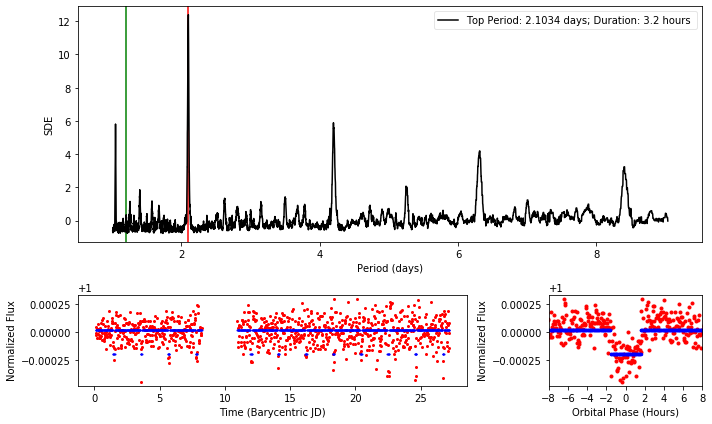

injected period:  2.103331802328962 versus BLS recovered period:  2.1034137219748854
injected variability period:  1.2034738542942789
alias check:  1.0


In [12]:
t = newtime; f=gpflatten_lc3b
R_star = 0.1# *Rad_sun
M_star = 0.1#*Mass_Sun

spacing = 0.02
fs = 9

minP=1.01
maxP= (max(newtime)-min(newtime)) #length of our light curve
minDur = 1.0/24.0
maxDur = 5.0/24.0

#creating list of orbital periods to model with
periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

durations = np.linspace(minDur,maxDur,25)

bls = BoxLeastSquares(t, f)
bls_power = bls.power(periods, durations)
bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)

#phase folding with best BLS model
index = np.argmax(bls_power.power); 
best_period = bls_power.period[index]; 
best_t0 = bls_power.transit_time[index];
BLS_depths=bls_power.depth[index]
BLS_dur = bls_power.duration[index]

#creating the best fit box model to our data
bls_model=bls.model(t,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])

p = best_period
x_fold = (t - best_t0 + 0.5*p) % p - 0.5*p


gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(gs1[:-1, :])
ax2 = fig.add_subplot(gs1[-1, :-1])
ax3 = fig.add_subplot(gs1[-1, -1])

ax1.axvline(x=ma.per,color='r')
ax1.axvline(2*np.pi/frequency,color='g')
ax1.plot(bls_power.period, bls_SDE, color='k',rasterized=True, label='Top Period: '+str( np.round(best_period,4) )+" days; Duration: "+str(np.round(24*BLS_dur,3))+" hours ") #rounding period to 4 decimal places 
plt.xticks(np.arange(0.0, 31.0, 1.0))
ax1.set_xlabel("Period (days)")
ax1.set_xlim(np.min(bls_power.period)-0.5, np.max(bls_power.period)+0.5)
ax1.set_ylabel("SDE")
ax1.set_ylim(np.min(bls_SDE)-0.5, np.max(bls_SDE)+0.5)
ax1.legend(loc='best',fancybox=True,framealpha=0.5)

ax2.plot(t,f,c='red',markersize=4,marker='.',linestyle='none',zorder=1)
ax2.plot(t,bls_model,'b.',markersize=2)
# ax2.set_ylim(np.min(f)-spacing, np.max(f)+spacing)
ax2.set_xlabel("Time (Barycentric JD)")
ax2.set_ylabel("Normalized Flux") 

ax3.plot(24*x_fold,f,c='red',markersize=6,marker='.',linestyle='none',zorder=1)
ax3.plot(24*x_fold,bls_model,'b.',markersize=5,label='BLS model')
ax3.set_xlabel("Orbital Phase (Hours)")
ax3.set_ylabel("Normalized Flux") 
# ax3.set_ylim(np.min(f)-spacing, np.max(f)+spacing)
ax3.set_xticks(np.arange(-10,15,2)) #hours
ax3.set_xlim(-2.5*BLS_dur*24,2.5*BLS_dur*24)
gs1.tight_layout(fig)

plt.show()

print("injected period: ", ma.per, "versus BLS recovered period: ", best_period)
print("injected variability period: ", (2*np.pi/frequency))
if best_period > ma.per:
    print("alias check: ", np.round(best_period/ma.per,2))
else:    
    print("alias check: ", np.round(ma.per/best_period,2))

## Notice the "wings" in the lower right figure. This is an example of why GP is not perfect. Perhaps, an additional step to take is to apply the Biweight midcorrelation filter to this already GP'd data

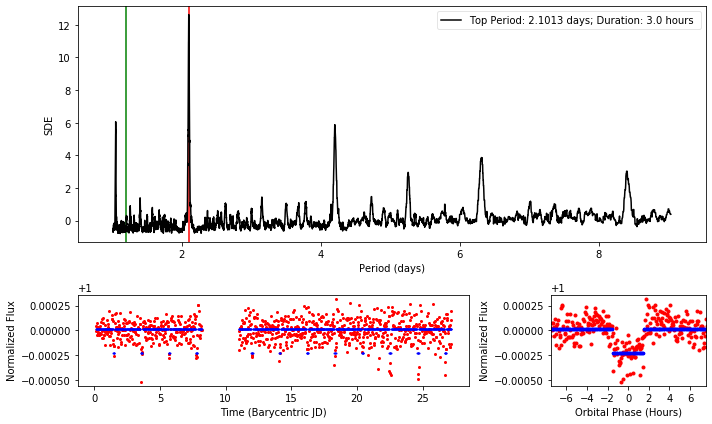

injected period:  2.103331802328962 versus BLS recovered period:  2.1012550690584746
injected variability period:  1.2034738542942789
alias check:  1.0


In [14]:
t = newtime; f=gpflatten_lc3b

flatten_lc, trend_lc = flatten(t, f, window_length=0.39, return_trend=True,robust=True,method='biweight')

T,F = t, flatten_lc
# fig=plt.figure()
# fig.add_subplot(211)
# plt.plot(t, f, 'k.')
# plt.plot(t, trend_lc, 'r-')
# plt.xlabel('Time (days)')
# plt.ylabel('Flux')

# fig.add_subplot(212)

mask = np.where(np.isnan(F)==False)[0]
T = T[mask]; F=F[mask]

# plt.plot(t,f,'r.')
# plt.xlabel('Time (days)')
# plt.ylabel('Flux')
# plt.show();

R_star = 0.1# *Rad_sun
M_star = 0.1#*Mass_Sun

spacing = 0.02
fs = 9

minP=1.01
maxP= (max(newtime)-min(newtime)) #length of our light curve
minDur = 1.0/24.0
maxDur = 5.0/24.0

#creating list of orbital periods to model with
periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

durations = np.linspace(minDur,maxDur,25)

bls = BoxLeastSquares(T, F)
bls_power = bls.power(periods, durations)
bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)

#phase folding with best BLS model
index = np.argmax(bls_power.power); 
best_period = bls_power.period[index]; 
best_t0 = bls_power.transit_time[index];
BLS_depths=bls_power.depth[index]
BLS_dur = bls_power.duration[index]

#creating the best fit box model to our data
bls_model=bls.model(T,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])

p = best_period
x_fold = (T - best_t0 + 0.5*p) % p - 0.5*p


gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(gs1[:-1, :])
ax2 = fig.add_subplot(gs1[-1, :-1])
ax3 = fig.add_subplot(gs1[-1, -1])

ax1.axvline(x=ma.per,color='r')
ax1.axvline(2*np.pi/frequency,color='g')
ax1.plot(bls_power.period, bls_SDE, color='k',rasterized=True, label='Top Period: '+str( np.round(best_period,4) )+" days; Duration: "+str(np.round(24*BLS_dur,3))+" hours ") #rounding period to 4 decimal places 
plt.xticks(np.arange(0.0, 31.0, 1.0))
ax1.set_xlabel("Period (days)")
ax1.set_xlim(np.min(bls_power.period)-0.5, np.max(bls_power.period)+0.5)
ax1.set_ylabel("SDE")
ax1.set_ylim(np.min(bls_SDE)-0.5, np.max(bls_SDE)+0.5)
ax1.legend(loc='best',fancybox=True,framealpha=0.5)

ax2.plot(T,F,c='red',markersize=4,marker='.',linestyle='none',zorder=1)
ax2.plot(T,bls_model,'b.',markersize=2)
# ax2.set_ylim(np.min(f)-spacing, np.max(f)+spacing)
ax2.set_xlabel("Time (Barycentric JD)")
ax2.set_ylabel("Normalized Flux") 

ax3.plot(24*x_fold,F,c='red',markersize=6,marker='.',linestyle='none',zorder=1)
ax3.plot(24*x_fold,bls_model,'b.',markersize=5,label='BLS model')
ax3.set_xlabel("Orbital Phase (Hours)")
ax3.set_ylabel("Normalized Flux") 
# ax3.set_ylim(np.min(f)-spacing, np.max(f)+spacing)
ax3.set_xticks(np.arange(-10,15,2)) #hours
ax3.set_xlim(-2.5*BLS_dur*24,2.5*BLS_dur*24)
gs1.tight_layout(fig)

plt.show()

print("injected period: ", ma.per, "versus BLS recovered period: ", best_period)
print("injected variability period: ", (2*np.pi/frequency))
if best_period > ma.per:
    print("alias check: ", np.round(best_period/ma.per,2))
else:    
    print("alias check: ", np.round(ma.per/best_period,2))



# Pretty good for oscillations more than 1 day. Not so much for faster variability less than 1 day...   

In [ ]:
# %reset -s -f

In [ ]:
print(len(t),len(f))